In [1]:
# Import libraries
using Turing
using LinearAlgebra
using Distributions
using MultivariateStats
import MultivariateStats: reconstruct
using GaussianProcesses
using StatsBase
using Statistics
using Suppressor
using JLD2
using CSV
using Optim
using DataFrames, DataFramesMeta
using SplitApplyCombine
using KernelFunctions
using MCMCChains
using PyCall
using PyPlot
using Printf
import PyCall.pyfunction
using Plots

# Access the matplotlib module
matplotlib = pyimport("matplotlib")
seaborn = pyimport("seaborn")
pyimport("scienceplots")
np = pyimport("numpy")
skl_model_selection = pyimport("sklearn.model_selection")
plt.style.use(["default","science","no-latex"])

include("../Utils/scale_utils.jl")
using .ScaleUtils

include("../Utils/gp_utils.jl")
using .GPUtils

# Set a seed for reproducibility
using Random
Random.seed!(1);


SIZE=21
FONTSIZE=21
DOTCOLOR="green"
EDGECOLOR="gray"
plt.style.use(["default","science","no-latex"])

In [20]:
# PDF plotting package
matplotlib_backends_pdf = pyimport("matplotlib.backends.backend_pdf")
PdfPages = matplotlib_backends_pdf.PdfPages
const confidence = quantile(Normal(), (1+0.95)/2)  # 95% confidence interval

1.9599639845400576

In [3]:
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################
###############################                Emulator Cross Validation                        #####################
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################

In [4]:
# Input parameter samples from (Jantre 2024)
data = CSV.read("../Data/Training_Data/Amery_Input_Parameters_Filtered.csv", DataFrame)
rename!(data, :Column1 => :index)
DataFrames.transform!(data, :index => ByRow(x -> x + 1) => :index);

In [5]:
#Scale the parameters to [0,1] range 
vmThresh_min, vmThresh_max = minimum(data.vmThresh), maximum(data.vmThresh)
scaler_vmThresh = fit(UnitRangeTransform, data.vmThresh)
d_01 = StatsBase.transform(scaler_vmThresh, data.vmThresh)

fricExp_min, fricExp_max = minimum(data.fricExp), maximum(data.fricExp)
scaler_fricExp = fit(UnitRangeTransform, data.fricExp)
d_02 = StatsBase.transform(scaler_fricExp, data.fricExp)

mu_scale_min, mu_scale_max = minimum(data.mu_scale), maximum(data.mu_scale)
scaler_mu_scale = fit(UnitRangeTransform, data.mu_scale)
d_03 = StatsBase.transform(scaler_mu_scale, data.mu_scale)

stiff_scale_min, stiff_scale_max = minimum(data.stiff_scale), maximum(data.stiff_scale)
scaler_stiff_scale = fit(UnitRangeTransform, data.stiff_scale)
d_04 = StatsBase.transform(scaler_stiff_scale, data.stiff_scale)

gamma0_min, gamma0_max = minimum(data.gamma0), maximum(data.gamma0)
scaler_gamma0 = fit(UnitRangeTransform, data.gamma0)
d_05 = StatsBase.transform(scaler_gamma0, data.gamma0)

melt_flux_min, melt_flux_max = minimum(data.melt_flux), maximum(data.melt_flux)
scaler_melt_flux = fit(UnitRangeTransform, data.melt_flux)
d_06 = StatsBase.transform(scaler_melt_flux, data.melt_flux)

design_scaled = DataFrame(vmThresh_scaled=d_01, fricExp_scaled=d_02, mu_scale_scaled=d_03,
                        stiff_scale_scaled=d_04, gamma0_scaled=d_05, melt_flux_scaled=d_06);


In [6]:
#Grounded volume change observable time series data from MALI projections
y_vol_raw = CSV.read("../Data/Training_Data/Amery_Grd_Vol_Change_time_series_2300_ssp5.csv", DataFrame)


# 2) Convert each to a plain 119×285 Array
# 2.1. Not(1) drops the first column
# 2.2. Matrix(...) converts the DataFrame to a plain Matrix 
# 2.3. ...') transposes the Matrix 
# 2.4. collect(...) turns the transpose matrix into a real Array
y_vol_fut = collect(Matrix(select(y_vol_raw, Not(1))));

# 3) Build the list of “representative” years and their column‐indices
gap = 15
years = [y for y in 2030:gap:2300]

# Since column 1 of y_cal corresponds to year 2016, column i ↦ year = 2015 + i.
# So to get year Y, use col = (Y – 2015). Equivalently: (Y - 2016) + 1.
col_idx = (years .- 2016) 
#println(col_idx)

# 4) Subset columns of the 119×285 matrix:
y_vol_sub = y_vol_fut[:,col_idx]
# # 5) Build column names for these subset columns:
colnames_vol = Symbol.("y_vol_" .* string.(years))
# 6) Wrap each matrix in a DataFrame, then scale **each column** to [0,1]:
df_y_vol_all = DataFrame(y_vol_sub, colnames_vol)

# Scale the volume data, get the scale factors, as well as minimums and maximums
y_vol_scaled, y_vol_scalers, y_vol_mins, y_vol_maxs =
    ScaleUtils.get_scaled_matrix(df_y_vol_all, colnames_vol)

#Collect the above into one vector for use later
vol_data = [y_vol_scaled, y_vol_scalers, y_vol_mins, y_vol_maxs]

# Mapping year to index of matrix for later use
vol_idx = Dict(name => idx for (idx, name) in enumerate(colnames_vol));

In [7]:
function five_fold_validation(X, y)

        # K-fold cross validation of the GP emulator
        num_folds = 5
        
        # Set a random seed for reproducibility
        np.random.seed(42)
        
        # Create K-fold cross-validator with the specified number of folds
        kf = skl_model_selection.KFold(n_splits=num_folds, shuffle=true, random_state=42)

        # Initializing empty vectors for predicted quantities and the indices used for testing 
        pred_mean_test = Vector{Float64}()
        pred_std_test = Vector{Float64}()
        test_indices = Vector{Int64}()
        
        for (train_idx, test_idx) in enumerate(kf.split(X'))
            train_idx, test_idx = (train_idx, test_idx)[2]
            train_idx = [x + 1 for x in train_idx]  # training data indices in current fold
            test_idx = [x + 1 for x in test_idx]  # test data indices in current fold
            append!(test_indices, test_idx)
            
            X_train_fold = X[:,train_idx]
            y_train_fold = y[train_idx]
            print(size(X_train_fold),size(y_train_fold),size(test_idx))
            print("\n")
            
            mZero = GaussianProcesses.MeanLin([0.0,0.0,0.0,0.0,0.0,0.0]) # linear mean function
            kern = Mat52Ard([0.0,0.0,0.0,0.0,0.0,0.0], 0.001) # Matern kernel function
            logObsNoise = -4.605170185985  
            # Since we have simulated data we do not have noise in data 
            # so we keep it constant: sig=0.01 hence log(sig)=-4.605170185985
        
            gp = GaussianProcesses.GP(X_train_fold, y_train_fold[:], mZero, kern, logObsNoise)
            
            iters = 100
            max_retries = 5
            
            for attempt in 0:5
                    
                res = optimize!(gp; domean=true, kern=true, noise=false, iterations=iters)
                # noise term is not trained since we want constant noise
        
                if Optim.converged(res)
                    success = true
                    break
                else
                    success = false
                    @warn "optimize! did not converge on attempt $(attempt+1) with $iters iterations."
                    if attempt < max_retries
                        iters *= 2
                        @info "Retrying with $iters iterations..."
                        gp = GaussianProcesses.GP(X_train_fold, y_train_fold[:], mZero, kern, logObsNoise)
                    end
                end
            end
            
            @info "Successfully trained emulator in $iters iterations."
            
            pred_mean, pred_var = GaussianProcesses.predict(gp, X[:,test_idx])
            pred_std = sqrt.(pred_var)
            append!(pred_mean_test, pred_mean)
            append!(pred_std_test, pred_std)
            
        end
    
        return pred_mean_test, pred_std_test, test_indices
end

five_fold_validation (generic function with 1 method)

In [8]:
function reorder_array_by_indices(original_array, corresponding_indices)
    # Create an array of tuples to hold values and indices
    data_with_indices = [(value,index) 
                            for (value,index) in zip(original_array, corresponding_indices)]
    
    # Sort the array of tuples based on indices
    sorted_data = sort(data_with_indices, by = x -> x[2])
    
    # Extract the values from the sorted tuples
    sorted_array = [value for (value, index) in sorted_data]
    
    return sorted_array
end


reorder_array_by_indices (generic function with 1 method)

In [19]:
# Function to loop over all representative years (2030:15:2300), perform cross validation for a scalar GP Emulator for each year
function gp_residual_eval(observable,scaled_inputs, column_indices)
    
    scaled_data = observable[1]
    scale_factors = observable[2]
    data_mins = observable[3]
    data_maxs = observable[4]

    all_mean_predictions = zeros(19,119)
    all_mean_truth       = zeros(19,119)
    all_residuals        = zeros(19,119)
    all_pred_lower       = zeros(19,119)
    all_pred_upper       = zeros(19,119)
 
        #For each representative year's worth of data
        for (idx, key) in enumerate(keys(sort(column_indices)))
    
            year_label = string(key)
            println("Current year : ", year_label)
            #get this years column data
            index = column_indices[key]
            y = scaled_data[:,index]
            #Complete five fold validation on that column data
            pred_mean_test, pred_std_test, test_indices = five_fold_validation(scaled_inputs, y)
            
            pred_mean_test = reorder_array_by_indices(pred_mean_test, test_indices)
            pred_std_test = reorder_array_by_indices(pred_std_test, test_indices)
    
            # Calculate confidence intervals
            pred_lower_test = pred_mean_test - confidence * pred_std_test
            pred_upper_test = pred_mean_test + confidence * pred_std_test
    
            #Unscale result        
            pred_mean_test_unscale = StatsBase.reconstruct(scale_factors[key], pred_mean_test)
            pred_lower_test_unscale = StatsBase.reconstruct(scale_factors[key], pred_lower_test)
            pred_upper_test_unscale = StatsBase.reconstruct(scale_factors[key], pred_upper_test)
            pred_std_test_unscale = (pred_upper_test_unscale - pred_mean_test_unscale)/confidence
            actual_test = StatsBase.reconstruct(scale_factors[key], y[:])
            #Calculate residuals
            residual_test = actual_test - pred_mean_test_unscale
            correlation_coefficient = cor(y[:], pred_mean_test)
            println(size(pred_mean_test_unscale))
            println(size(pred_lower_test_unscale))
            println(size(pred_upper_test_unscale))
            println(size(pred_std_test_unscale))
            println(size(residual_test))
            println(typeof(pred_mean_test_unscale))
            println("Pearson Correlation Coefficient = $correlation_coefficient")

            all_mean_predictions[idx,:] = pred_mean_test_unscale
            all_mean_truth[idx,:]       = actual_test
            all_residuals[idx,:]        = residual_test
            all_pred_lower[idx,:]       = pred_lower_test_unscale
            all_pred_upper[idx,:]       = pred_upper_test_unscale
  
        end

    return all_mean_predictions, all_mean_truth, all_residuals, all_pred_lower, all_pred_upper      
        
end

       

gp_residual_eval (generic function with 1 method)

In [12]:
#Transpose the input matrix
X = Matrix(design_scaled)' 
# Unscale the parameters for pairwise residual plots
vmThresh_test = StatsBase.reconstruct(scaler_vmThresh,X[1,:])
fricExp_test = StatsBase.reconstruct(scaler_fricExp,X[2,:])
mu_scale_test = StatsBase.reconstruct(scaler_mu_scale,X[3,:])
stiff_scale_test = StatsBase.reconstruct(scaler_stiff_scale,X[4,:])
gamma0_test = StatsBase.reconstruct(scaler_gamma0,X[5,:])
melt_flux_test = StatsBase.reconstruct(scaler_melt_flux,X[6,:])
input_params = [vmThresh_test, fricExp_test, mu_scale_test, stiff_scale_test, gamma0_test, melt_flux_test ]

#Define plot saveout location
pdf_pages = PdfPages("../Plots/Scalar_Emulator_Diagnostic_Plots/all_years_emulator_validation_plots.pdf")

# Call the validation function on the scaled data, save the outputs into variables for plotting
mean_predictions, mean_truths, residuals, lowers, uppers = gp_residual_eval(vol_data, X, vol_idx)



Current year : y_vol_2030
6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...


(6

[ Info: Successfully trained emulator in 200 iterations.


, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 200 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 200 iterations.
[ Info: Successfully trained emulator in 100 iterations.


(6, 96)(96,)(23,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...


(119,)
(119,)
(119,)
(119,)
(119,)
Vector

[ Info: Successfully trained emulator in 200 iterations.


{Float64}
Pearson Correlation Coefficient = 0.9316344323674964
Current year : y_vol_2045
(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 200 iterations.
[ Info: Successfully trained emulator in 100 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...


(6, 96)(96,)(23,)


[ Info: Successfully trained emulator in 200 iterations.
[ Info: Successfully trained emulator in 100 iterations.


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9527645714572089
Current year : y_vol_2060
(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 200 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 200 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...


(6, 96)(96,)(23,)


[ Info: Successfully trained emulator in 200 iterations.
[ Info: Successfully trained emulator in 100 iterations.


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9731523331152482
Current year : y_vol_2075
(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 100 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 96)(96,)(23,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9812584315818429
Current year : y_vol_2090
(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 200 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 96)(96,)(23,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9886061695824907
Current year : y_vol_2105
(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
┌ Warning: optimize! did not converge on attempt 2 with 200 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 400 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 400 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 96)(96,)(23,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9896157203080447
Current year : y_vol_2120
(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 100 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
┌ Warning: optimize! did not converge on attempt 2 with 200 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 400 iterations...


(6, 96)(96,)(23,)


[ Info: Successfully trained emulator in 400 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9908561912878358
Current year : y_vol_2135
(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 200 iterations.
[ Info: Successfully trained emulator in 100 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 200 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 96)(96,)(23,)


[ Info: Successfully trained emulator in 100 iterations.


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9910675288817653
Current year : y_vol_2150
(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 100 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 200 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...


(6, 96)(96,)(23,)


[ Info: Successfully trained emulator in 200 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9888268335023563
Current year : y_vol_2165
(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 200 iterations.
[ Info: Successfully trained emulator in 100 iterations.


(6, 96)(96,)(23,)


[ Info: Successfully trained emulator in 100 iterations.


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9911186295181263
Current year : y_vol_2180
(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 100 iterations.


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 100 iterations.


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 100 iterations.


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 100 iterations.


(6, 96)(96,)(23,)


[ Info: Successfully trained emulator in 100 iterations.


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9893882101048983
Current year : y_vol_2195
(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 100 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 100 iterations.


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 100 iterations.


(6, 96)(96,)(23,)


[ Info: Successfully trained emulator in 100 iterations.


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9862443916879194
Current year : y_vol_2210
(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
┌ Warning: optimize! did not converge on attempt 2 with 200 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 400 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 400 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 100 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 96)(96,)(23,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9607422022534422
Current year : y_vol_2225
(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
┌ Warning: optimize! did not converge on attempt 2 with 200 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 400 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 400 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
┌ Warning: optimize! did not converge on attempt 2 with 200 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 400 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 400 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
┌ Warning: optimize! did not converge on attempt 2 with 200 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 400 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 400 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
┌ Warning: optimize! did not converge on attempt 2 with 200 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 400 iterations...
[ Info: Successfully trained emulator in 400 iterations.


(6, 96)(96,)(23,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
┌ Warning: optimize! did not converge on attempt 2 with 200 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 400 iterations...


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9455517050058426
Current year : y_vol_2240
(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 400 iterations.
[ Info: Successfully trained emulator in 100 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
┌ Warning: optimize! did not converge on attempt 2 with 200 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 400 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 400 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
┌ Warning: optimize! did not converge on attempt 2 with 200 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 400 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 400 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 96)(96,)(23,)


[ Info: Successfully trained emulator in 100 iterations.


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9468242826149825
Current year : y_vol_2255
(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 96)(96,)(23,)


[ Info: Successfully trained emulator in 100 iterations.


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9699918557757771
Current year : y_vol_2270
(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
┌ Warning: optimize! did not converge on attempt 2 with 200 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 400 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 400 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 96)(96,)(23,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9817465588273083
Current year : y_vol_2285
(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
┌ Warning: optimize! did not converge on attempt 2 with 200 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 400 iterations...
[ Info: Successfully trained emulator in 400 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 96)(96,)(23,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9867293836076182
Current year : y_vol_2300
(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 200 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
┌ Warning: optimize! did not converge on attempt 2 with 200 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 400 iterations...


(6, 95)(95,)(24,)


[ Info: Successfully trained emulator in 400 iterations.
┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 95)(95,)(24,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
[ Info: Successfully trained emulator in 200 iterations.


(6, 96)(96,)(23,)


┌ Warning: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 200 iterations...
┌ Warning: optimize! did not converge on attempt 2 with 200 iterations.
└ @ Main In[7]:49
[ Info: Retrying with 400 iterations...


(119,)
(119,)
(119,)
(119,)
(119,)
Vector{Float64}
Pearson Correlation Coefficient = 0.9881617560495659


[ Info: Successfully trained emulator in 400 iterations.


([-111.1515699723862 272.61949474562414 … -294.9400315909692 301.838382542834; -171.86608291224474 732.6851844333232 … -428.63697391918856 774.3421044089193; … ; -75736.72327960885 -37881.41854661812 … -65027.299306857065 -30012.695707174382; -78308.06102468795 -38174.90549910338 … -65739.80846697406 -29670.319921074], [-90.4460525852628 293.3578253686428 … -400.53305008495227 305.8840857371688; -29.21089192572981 744.4336833013222 … -512.8402997045778 765.1676394306123; … ; -73578.82369255787 -37948.85233373614 … -64748.70172743872 -29173.433676050976; -74921.70368463546 -38048.81328613544 … -65749.8666374893 -29178.7602545307], [20.705517387123393 20.73833062301867 … -105.59301849398304 4.045703194334806; 142.65519098651492 11.748498867998933 … -84.20332578538921 -9.174464978307014; … ; 2157.8995870509825 -67.43378711801779 … 278.59757941834687 839.2620311234059; 3386.357340052491 126.0922129679384 … -10.058170515228994 491.55966654329677], [-203.27246499196812 228.5365139851301 … -4

In [66]:
# List of analysis years
analysis_years = collect(range(2030,step=15,length=19))

try
    for i in 1:19
        diagnostics_plots(mean_predictions[i,:], mean_truths[i,:], residuals[i,:], lowers[i,:], uppers[i,:], input_params, analysis_years[i], pdf_pages, confidence)

    end
finally 
    pdf_pages.close()
end



2030
2045
2060
2075
2090
2105
2120
2135
2150
2165
2180
2195
2210
2225
2240
2255
2270
2285
2300


2150
2300


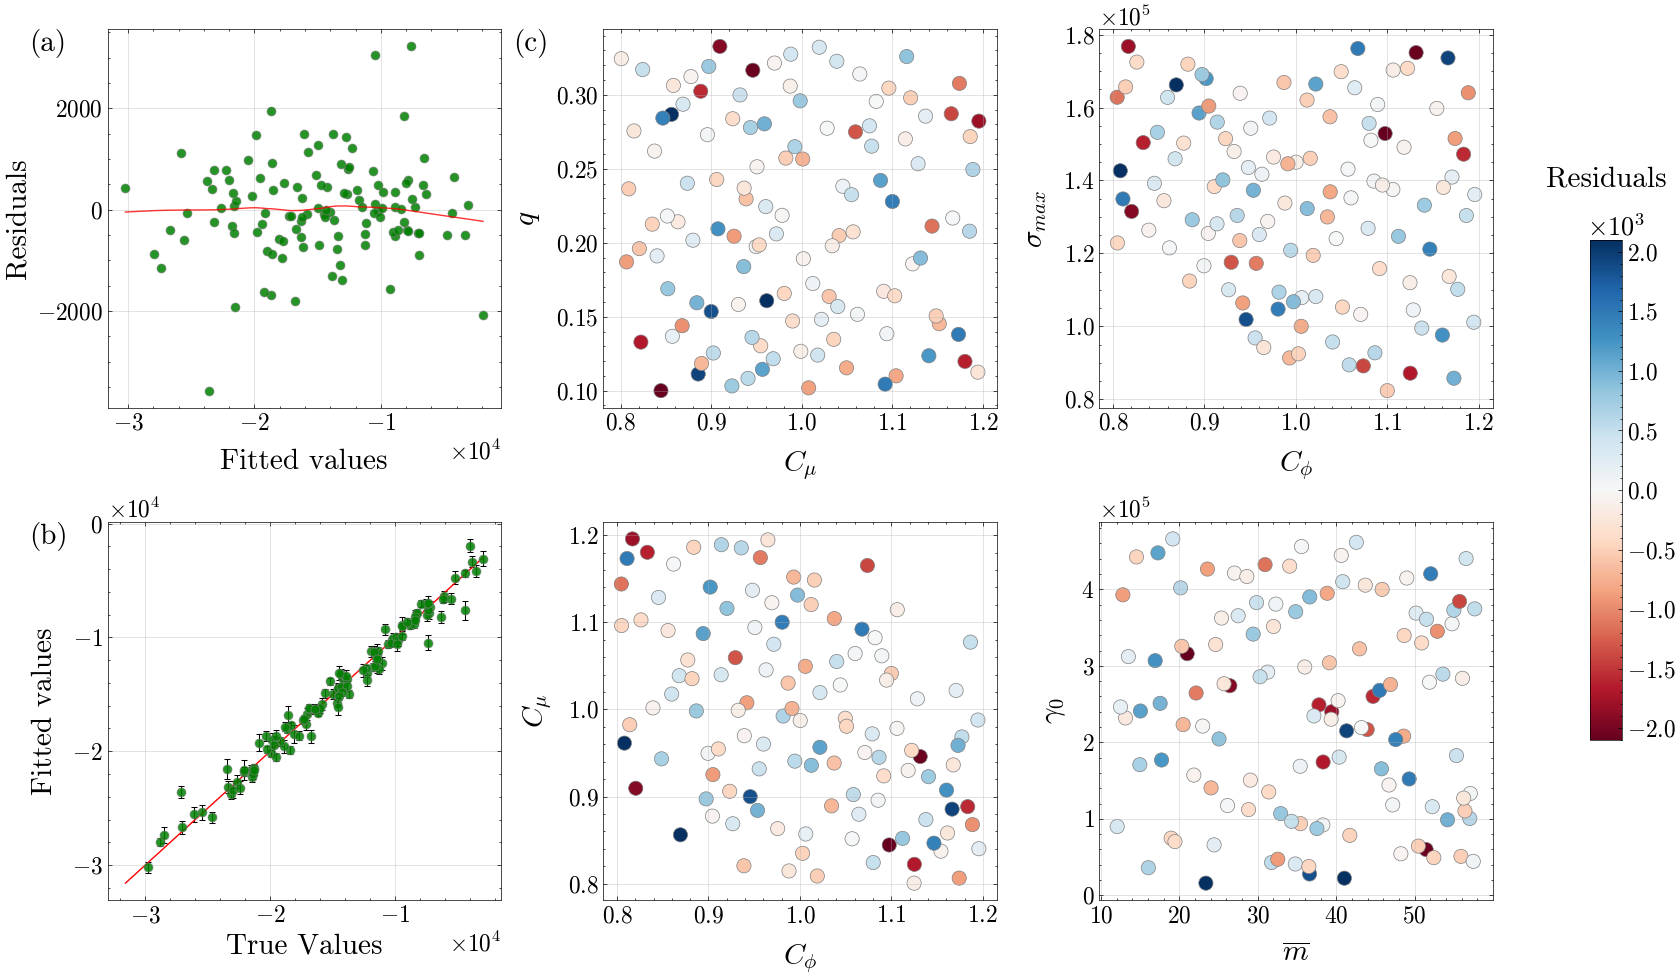

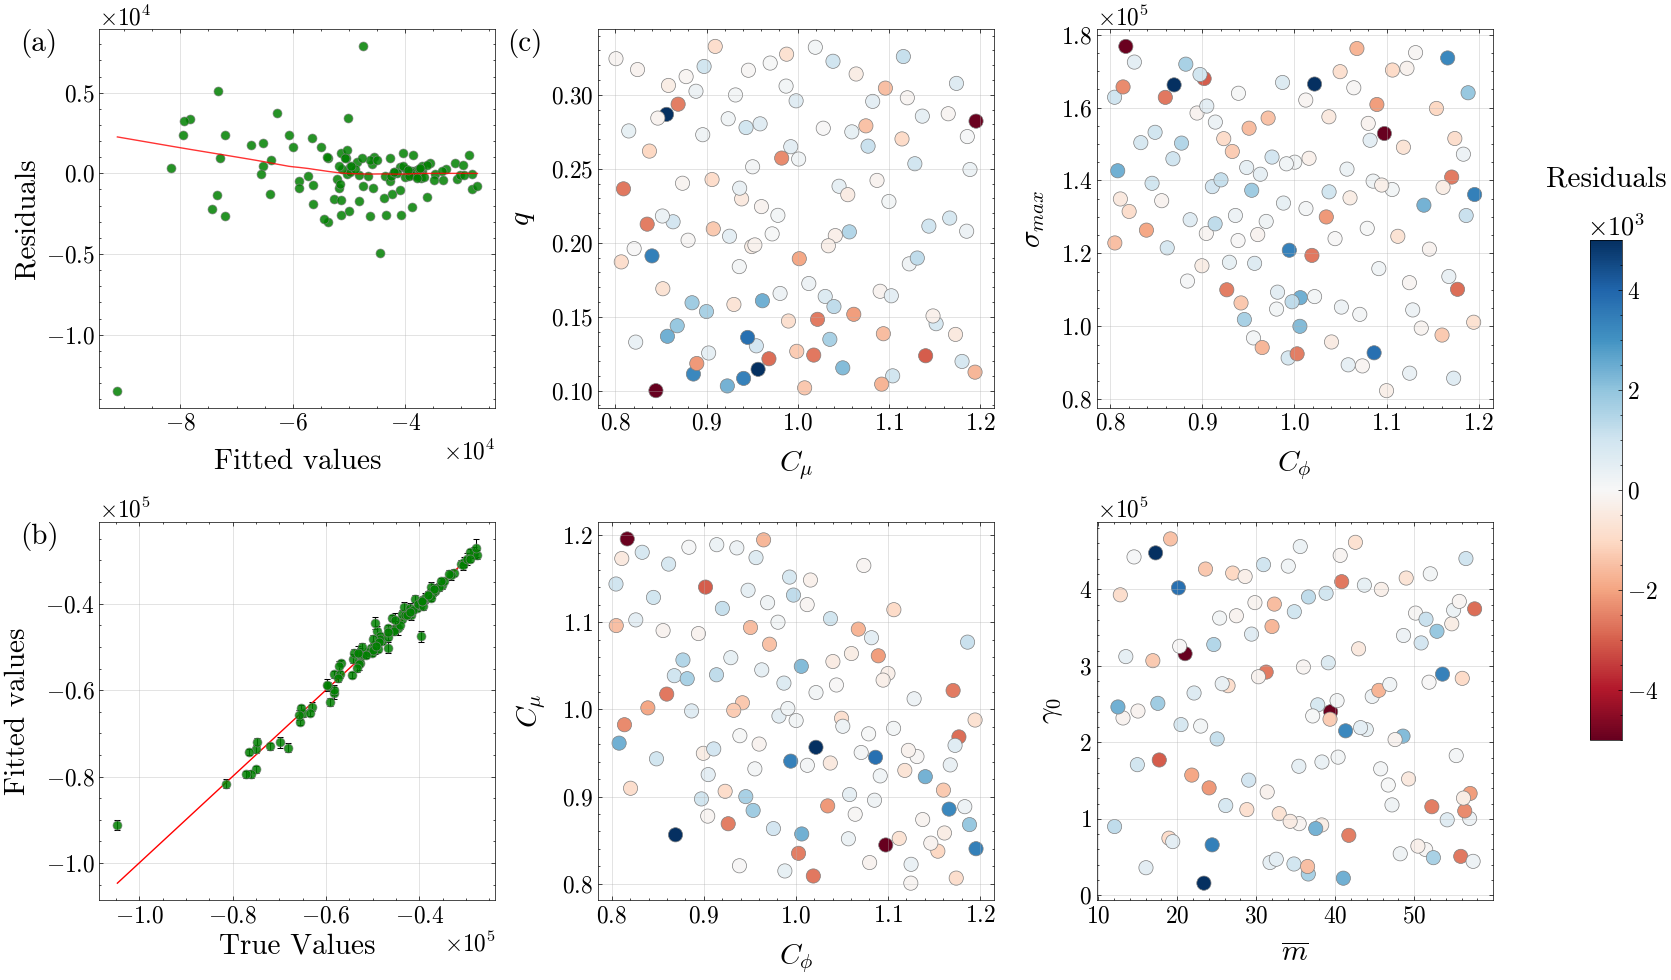

In [64]:
climits_2150 = [-2100,2100]
climits_2300 = [-5000,5000] 
idx_2150 = findfirst(==(2150), analysis_years)
idx_2300 = findfirst(==(2300), analysis_years)
paper_plots(mean_predictions[idx_2150,:], mean_truths[idx_2150,:], residuals[idx_2150,:], lowers[idx_2150,:], uppers[idx_2150,:], input_params, 2150, confidence, climits_2150)
paper_plots(mean_predictions[idx_2300,:], mean_truths[idx_2300,:], residuals[idx_2300,:], lowers[idx_2300,:], uppers[idx_2300,:], input_params, 2300, confidence, climits_2300)

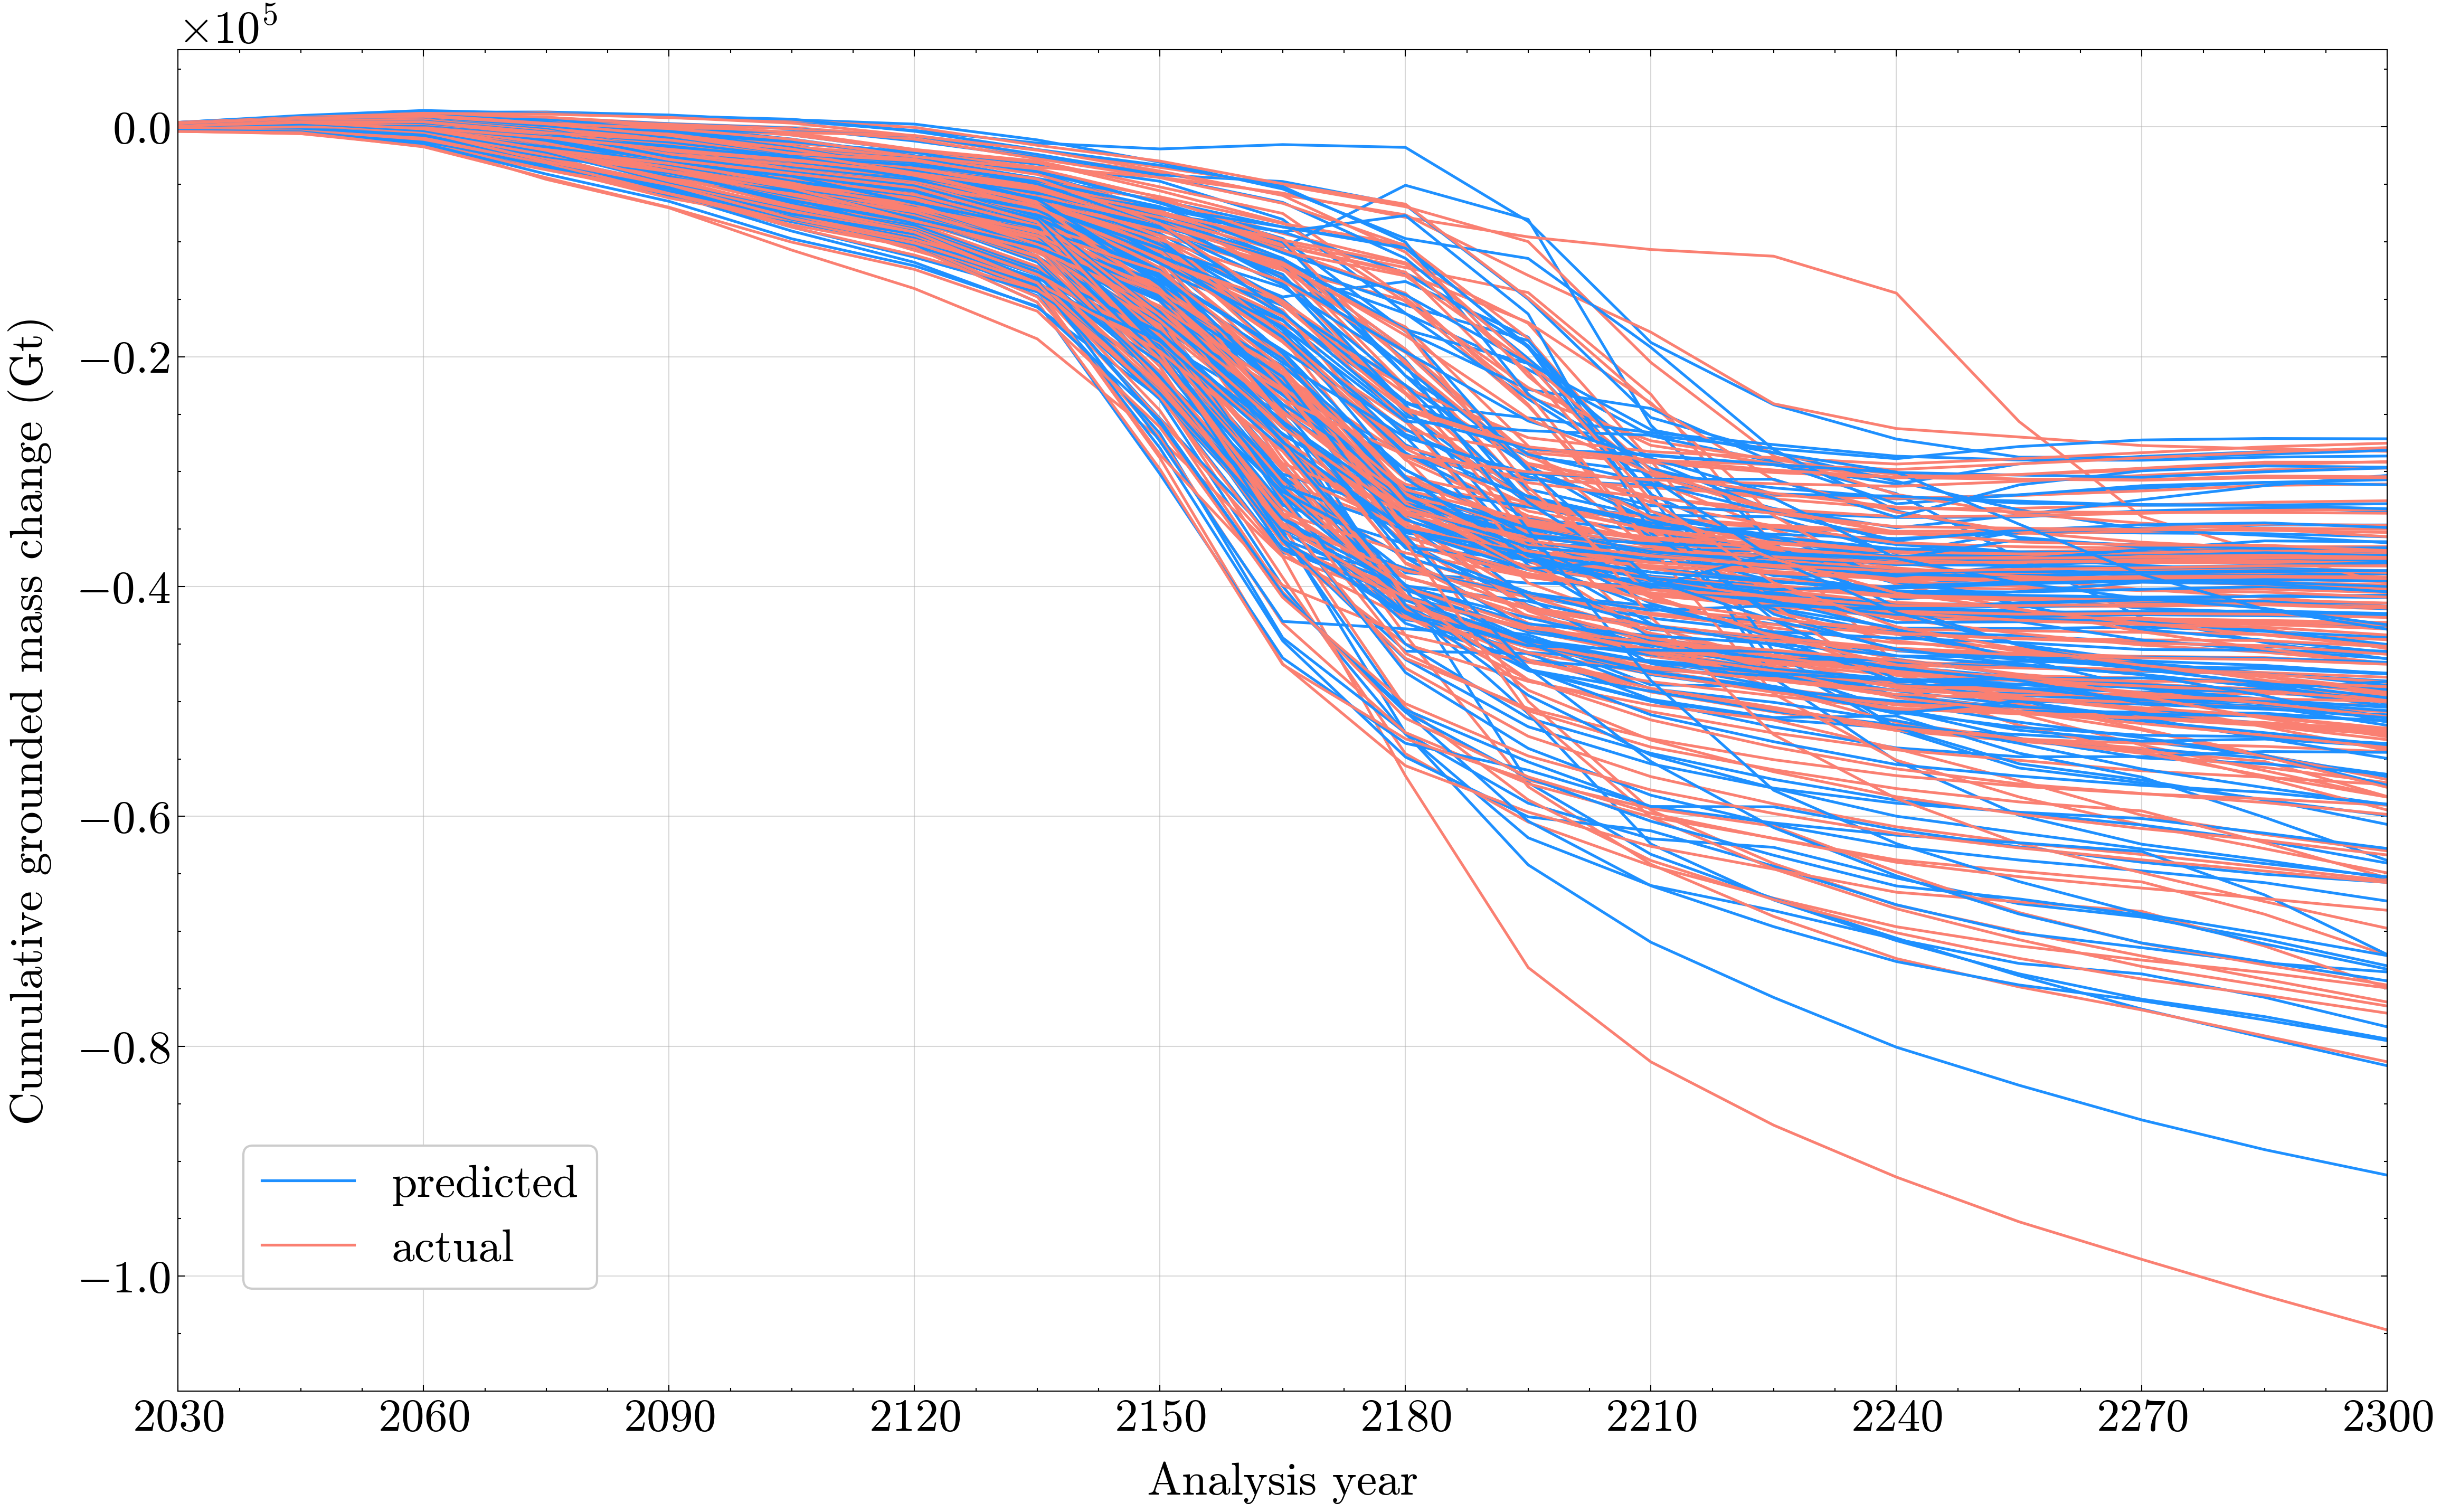

In [40]:
# PREDICTED VS ACTUAL PLOT FROM CROSS VALIDATION
fig, ax = PyPlot.subplots(nrows=1, ncols=1, figsize=(18, 11), dpi=300)
# Transpose the matrices to get their time series representations
ts_mean_prediction = mean_predictions'
ts_mean_truth = mean_truths'
for i in 1:119
    ax.plot(analysis_years, ts_mean_prediction[i,:], color = "dodgerblue", label = "predicted" ,lw=1.25)
    ax.plot(analysis_years, ts_mean_truth[i,:], color = "salmon", label = "actual" , lw=1.25)
end

ax.set_xlabel("Analysis year", fontsize= FONTSIZE, labelpad=10)
ax.set_ylabel("Cumulative grounded mass change (Gt)", fontsize= FONTSIZE, labelpad=10)
ax.tick_params(axis="both", which="major", labelsize=FONTSIZE)
ax.set_xlim(2030,2300)
# ax.set_ylim(ylim_dict[chosen_year])
ax.set_xticks(collect(range(2030, step=30, length=10)))
# ax.set_yticks(yticks_dict[chosen_year])
ax.ticklabel_format(axis="y", style="sci", scilimits=(-3,3), useMathText=true)
ax.yaxis.offsetText.set_fontsize(FONTSIZE)
ax.grid(true, alpha=0.5, zorder=1)
handles, labels = ax.get_legend_handles_labels()
n = length(handles)
desired_indices = [1,130] 
sorted_handles = [handles[i] for i in desired_indices]
sorted_labels = [labels[i] for i in desired_indices]
ax.legend(sorted_handles, sorted_labels, ncol=1, fontsize=FONTSIZE,
   bbox_to_anchor=(0.2, 0.2), frameon="True", framealpha=1)

PyPlot.savefig("../Plots/Scalar_Emulator_Diagnostic_Plots/crs_val_predicted_vs_actual.pdf",bbox_inches="tight",dpi=300)

In [12]:
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################
###############################                Emulator Full Training             ###########################
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################

In [13]:
# Load input parameters from the respective CSV file
X_raw = CSV.read("../Data/Training_Data/Amery_Input_Parameters_Filtered.csv", DataFrame);

# 1) Grab all column‐names as Symbols
cols = Symbol.(names(X_raw))

# 2) Remove the index‐column symbol
cols = filter(c -> c != :Column1, cols)
println("Column names: ", cols)

# 3) Now call get_scaled_matrix on the remaining columns
X_scaled_t, X_scalers, X_mins, X_maxs = ScaleUtils.get_scaled_matrix(X_raw, cols);

X_scaled = X_scaled_t'

Column names: [:vmThresh, :fricExp, :mu_scale, :stiff_scale, :gamma0, :melt_flux]


6×119 adjoint(::Matrix{Float64}) with eltype Float64:
 0.407891   0.584329  0.879853  0.35452   …  0.89069    0.435987   0.727361
 0.0356264  0.509296  0.437061  0.789839     0.0620034  0.412618   0.840317
 0.354441   0.449709  0.200242  0.311622     0.394692   0.0504651  0.712968
 0.485306   0.770992  0.664396  0.733916     0.555406   0.342915   0.709687
 0.607262   0.45634   0.784528  0.921009     0.959423   0.688045   0.451809
 0.91086    0.239113  0.835963  0.482451  …  0.11399    0.180736   0.683243

In [14]:
# 1) Load future simulated observables from SSP ensemble loaded from their respective CSV file into a DataFrame

# Grounded Volume Change
y_grd_vol_raw = CSV.read("../Data/Training_Data/Amery_Grd_Vol_Change_time_series_2300_ssp5.csv", DataFrame)

# 2) Convert each to a plain 119×285 Array
# 2.1. Not(1) drops the first column
# 2.2. Matrix(...) converts the DataFrame to a plain Matrix 
# 2.3. collect(...) turns the transpose matrix into a real Array

y_grd_vol_fut = collect(Matrix(select(y_grd_vol_raw, Not(1))));

# 3) Build the list of “representative” years and their column‐indices
gap = 15
years = [y for y in 2015:gap:2300 if y != 2015]
# Since column 1 corresponds to year 2017, column i ↦ year = 2016 + i.
# So to get year Y, use col = (Y – 2016). Equivalently: (Y - 2017) + 1.
col_idx = (years .- 2016) 

# 4) Subset columns of the 119×285 matrix:

y_grd_vol_sub = y_grd_vol_fut[:, col_idx]

years_all  = years

y_grd_vol_all = hcat(y_grd_vol_sub)

# 5) Build column names for these subset columns:

colnames_grd_vol = Symbol.("y_grd_vol_" .* string.(years_all))
println(colnames_grd_vol)

# 6) Wrap each matrix in a DataFrame, then scale **each column** to [0,1]:

df_y_grd_vol_all = DataFrame(y_grd_vol_all, colnames_grd_vol)


y_grd_vol_scaled, y_grd_vol_scalers, y_grd_vol_mins, y_grd_vol_maxs =
    ScaleUtils.get_scaled_matrix(df_y_grd_vol_all, colnames_grd_vol);

@save "grd_vol_training_mins_maxs" y_grd_vol_mins y_grd_vol_maxs

[:y_grd_vol_2030, :y_grd_vol_2045, :y_grd_vol_2060, :y_grd_vol_2075, :y_grd_vol_2090, :y_grd_vol_2105, :y_grd_vol_2120, :y_grd_vol_2135, :y_grd_vol_2150, :y_grd_vol_2165, :y_grd_vol_2180, :y_grd_vol_2195, :y_grd_vol_2210, :y_grd_vol_2225, :y_grd_vol_2240, :y_grd_vol_2255, :y_grd_vol_2270, :y_grd_vol_2285, :y_grd_vol_2300]


In [15]:
# Train the validated emulators on the entire dataset
grd_vol_path = "../Data/Grd_vol_change_gap_$(gap)_emulators_test.jld2"
grd_vol_dict = GPUtils.train_all_emulators!(grd_vol_path, X_scaled, y_grd_vol_scaled, years_all;
                                 init_noise = -4.605170185985,
                                 base_iters = 100,
                                 max_retries = 5)

[ Info: File ../Data/Grd_vol_change_gap_15_emulators_test.jld2 not found—training all 19 emulators now.
[ Info: Successfully trained emulator for year 2030 in 100 iterations.
[ Info: Successfully trained emulator for year 2045 in 100 iterations.
[ Info: Successfully trained emulator for year 2060 in 100 iterations.
┌ Warning: Year 2075: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main.GPUtils ~/BrookhavenPaperDirectory/Utils/gp_utils.jl:81
[ Info: Retrying year 2075 with 200 iterations...
[ Info: Successfully trained emulator for year 2075 in 200 iterations.
┌ Warning: Year 2090: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main.GPUtils ~/BrookhavenPaperDirectory/Utils/gp_utils.jl:81
[ Info: Retrying year 2090 with 200 iterations...
[ Info: Successfully trained emulator for year 2090 in 200 iterations.
┌ Warning: Year 2105: optimize! did not converge on attempt 1 with 100 iterations.
└ @ Main.GPUtils ~/BrookhavenPaperDirectory/Utils/gp_utils.jl:

Dict{Int64, Any} with 19 entries:
  2030 => GP Exact object:…
  2180 => GP Exact object:…
  2255 => GP Exact object:…
  2300 => GP Exact object:…
  2075 => GP Exact object:…
  2120 => GP Exact object:…
  2270 => GP Exact object:…
  2060 => GP Exact object:…
  2240 => GP Exact object:…
  2195 => GP Exact object:…
  2090 => GP Exact object:…
  2285 => GP Exact object:…
  2105 => GP Exact object:…
  2210 => GP Exact object:…
  2165 => GP Exact object:…
  2225 => GP Exact object:…
  2045 => GP Exact object:…
  2135 => GP Exact object:…
  2150 => GP Exact object:…

In [65]:
function diagnostics_plots(predicted_means, actual_means, residuals, predicted_low, predicted_high, params, year,pdf_save, confidence)
    println(year)
    fig, ax = subplots(nrows=2, ncols=3, figsize=(16, 10))
    #fig.suptitle("GP fitting diagnostics for year: $year", fontsize=35)
    
    #### Regression plot with loess smoothing ###
    seaborn.regplot(x=predicted_means, y=residuals, lowess=true,
                    scatter_kws=Dict("alpha"=>0.85, "s"=> SIZE*2, "color"=>DOTCOLOR, 
                                     "edgecolor"=>EDGECOLOR, "linewidths"=>0.5,
                                     "plotnonfinite"=>false, "zorder"=>2), 
                    line_kws=Dict("color" => "red", "lw" => 1, "alpha" => 0.8), ax=ax[1,1])
    
    ax[1,1].set_ylabel("Residuals", fontsize=FONTSIZE)
    ax[1,1].set_xlabel("Fitted values", fontsize=FONTSIZE, labelpad=10)
    ax[1,1].grid(true, alpha=0.5, zorder=1)
    ax[1,1].ticklabel_format(style="sci", scilimits=(-4,4), useMathText=true)
    ax[1,1].tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
    ax[1,1].xaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    ax[1,1].yaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    #ax[1,1].set_ylim(-7, 7)
    # ax[1,1].set_xlim(-100,80)
    ax[1,1].locator_params(tight=true, nbins=6)
    ax[1,1].text(-0.2, 1, "(a)", ha="left", va="top", 
                     transform=ax[1,1].transAxes, fontsize=FONTSIZE)
    
    
    ### Scatter plot with error bars ###
    ax[2,1].scatter(x=actual_means, y=predicted_means, s=SIZE*2, c=DOTCOLOR,
                    alpha=0.85,edgecolor = EDGECOLOR, linewidth=0.5, 
                    plotnonfinite=false, zorder=4)
    (_, caps, _) = ax[2,1].errorbar(x=actual_means, y=predicted_means,
                                    yerr=quantile(Normal(), 
                                    (1+0.5)/2)*(1/confidence)*(predicted_high-predicted_means),
                                    elinewidth=0.75, capsize=2.5, color="black", linestyle="None", zorder=2)
    
    for cap in caps
        cap.set_markeredgewidth(0.75)
    end
    
    # Plotting the 45-degree line
    p1 = max(maximum(predicted_low), maximum(actual_means))
    p2 = min(minimum(predicted_low), minimum(actual_means))
    ax[2,1].plot([p1, p2], [p1, p2], "r-")
    
    ax[2,1].set_xlabel("True Values",fontsize=FONTSIZE)
    ax[2,1].set_ylabel("Fitted values",fontsize=FONTSIZE, labelpad=10)
    ax[2,1].locator_params(tight=true, nbins=6)
    ax[2,1].grid(true, alpha=0.5, zorder=1)
    ax[2,1].ticklabel_format(style="sci", scilimits=(-3,3), useMathText=true)
    ax[2,1].tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
    ax[2,1].xaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    ax[2,1].yaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    ax[2,1].annotate(L"-100", xy=(0, 0), xytext=(-125, -108), fontsize=FONTSIZE*0.8)
    ax[2,1].text(-0.2, 1, "(b)", ha="left", va="top", 
                     transform=ax[2,1].transAxes, fontsize=FONTSIZE)
    
    ### SCATTERS ####
    vmax = maximum(abs.(residuals))
    vmin = -vmax

    #vmin, vmax = 9,22.25 # 8.51,16.5 # 1.6,6.3 # 9,22.25
    # norm_ = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip="True")

    # Choose a sequential cmap and robust color limits for widths (since widths ≥ 0)

    # vmin, vmax = quantile(widths, [0.05, 0.95])   # robust limits; change to [minimum(widths), maximum(widths)] if you prefer
    # norm_ = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    ax[1,2].set_xlabel(L"C_{\mu}",fontsize=FONTSIZE, labelpad=10)
    ax[1,2].set_ylabel(L"q",fontsize=FONTSIZE, labelpad=10)
    im12 = ax[1,2].scatter(params[3], params[2], s=SIZE*5, c=residuals, # mu_scale_test, fricExp_test
            edgecolor = EDGECOLOR, linewidth=0.5, plotnonfinite=false, cmap="RdBu",vmin=vmin,vmax=vmax, zorder=2)
    ax[1,2].grid(true, alpha=0.5, zorder=1)
    ax[1,2].locator_params(tight=true, nbins=6)
    ax[1,2].ticklabel_format(style="sci", scilimits=(-3,3), useMathText=true)
    ax[1,2].tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
    ax[1,2].xaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    ax[1,2].yaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    ax[1,2].text(-0.23, 1, "(c)", ha="left", va="top", 
                     transform=ax[1,2].transAxes, fontsize=FONTSIZE)
    
    
    ax[1,3].set_xlabel(L"C_{\phi}",fontsize=FONTSIZE, labelpad=10)
    ax[1,3].set_ylabel(L"\sigma_{max}",fontsize=FONTSIZE, labelpad=10)
    im13 = ax[1,3].scatter(params[4], params[1], s=SIZE*5, c=residuals, # stiff_scale_test, vmThresh_test
            edgecolor = EDGECOLOR, linewidth=0.5, plotnonfinite=false, cmap="RdBu",vmin=vmin,vmax=vmax, zorder=2)
    ax[1,3].grid(true, alpha=0.5, zorder=1)
    ax[1,3].locator_params(tight=true, nbins=6)
    ax[1,3].ticklabel_format(style="sci", scilimits=(-3,3), useMathText=true)
    ax[1,3].tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
    ax[1,3].xaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    ax[1,3].yaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    
    
    ax[2,2].set_xlabel(L"C_{\phi}",fontsize=FONTSIZE, labelpad=10)
    ax[2,2].set_ylabel(L"C_{\mu}",fontsize=FONTSIZE, labelpad=10)
    im22 = ax[2,2].scatter(params[4], params[3], s=SIZE*5, c=residuals, # stiff_scale_test, mu_scale_test
            edgecolor = EDGECOLOR, linewidth=0.5, plotnonfinite=false, cmap="RdBu",vmin=vmin,vmax=vmax, zorder=2)
    ax[2,2].grid(true, alpha=0.5, zorder=1)
    ax[2,2].locator_params(tight=true, nbins=6)
    ax[2,2].ticklabel_format(style="sci", scilimits=(-3,3), useMathText=true)
    ax[2,2].tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
    ax[2,2].xaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    ax[2,2].yaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    
    
    ax[2,3].set_xlabel(L"\overline{m}",fontsize=FONTSIZE, labelpad=10)
    ax[2,3].set_ylabel(L"\gamma_0",fontsize=FONTSIZE, labelpad=10)
    im23 = ax[2,3].scatter(params[6], params[5], s=SIZE*5, c=residuals, # melt_flux_test, gamma0_test
            edgecolor = EDGECOLOR, linewidth=0.5, plotnonfinite=false, cmap="RdBu",vmin=vmin,vmax=vmax, zorder=2)
    ax[2,3].grid(true, alpha=0.5, zorder=1)
    ax[2,3].locator_params(tight=true, nbins=6)
    ax[2,3].ticklabel_format(style="sci", scilimits=(-3,3), useMathText=true)
    ax[2,3].tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
    ax[2,3].xaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    ax[2,3].yaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    
    
    plt.tight_layout()
    # cbar_ax = fig.add_axes([1.03, 0.25, 0.02, 0.5])
    # cbar12 = fig.colorbar(im12, cax=cbar_ax)
    # cbar22 = fig.colorbar(im22, cax=cbar_ax)
    # cbar13 = fig.colorbar(im13, cax=cbar_ax)
    # cbar23 = fig.colorbar(im23, cax=cbar_ax)
    # cbar23.ax.set_title("Residuals", fontsize=FONTSIZE, pad=20)
    # cbar23.ax.tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)


    cbar_ax = fig.add_axes([1.03, 0.25, 0.02, 0.5])
    cbar = fig.colorbar(im12, cax=cbar_ax)
    cbar.ax.set_title("Residuals", fontsize=FONTSIZE, pad=20)
    cbar.ax.tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
    cbar.ax.ticklabel_format(style="sci", scilimits=(-3,3), useMathText=true)

    #Set a title for the entire figure including year of data used
 
    
    pdf_save.savefig(fig)
    PyPlot.close(fig)

end

diagnostics_plots (generic function with 1 method)

In [63]:
function paper_plots(predicted_means, actual_means, residuals, predicted_low, predicted_high, params, year,confidence, climits)
    println(year)
    fig, ax = subplots(nrows=2, ncols=3, figsize=(16, 10))
    #### Regression plot with loess smoothing ###
    seaborn.regplot(x=predicted_means, y=residuals, lowess=true,
                    scatter_kws=Dict("alpha"=>0.85, "s"=> SIZE*2, "color"=>DOTCOLOR, 
                                     "edgecolor"=>EDGECOLOR, "linewidths"=>0.5,
                                     "plotnonfinite"=>false, "zorder"=>2), 
                    line_kws=Dict("color" => "red", "lw" => 1, "alpha" => 0.8), ax=ax[1,1])
    
    ax[1,1].set_ylabel("Residuals", fontsize=FONTSIZE)
    ax[1,1].set_xlabel("Fitted values", fontsize=FONTSIZE, labelpad=10)
    ax[1,1].grid(true, alpha=0.5, zorder=1)
    ax[1,1].ticklabel_format(style="sci", scilimits=(-4,4), useMathText=true)
    ax[1,1].tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
    ax[1,1].xaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    ax[1,1].yaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    #ax[1,1].set_ylim(-7, 7)
    # ax[1,1].set_xlim(-100,80)
    ax[1,1].locator_params(tight=true, nbins=6)
    ax[1,1].text(-0.2, 1, "(a)", ha="left", va="top", 
                     transform=ax[1,1].transAxes, fontsize=FONTSIZE)
    
    ### Scatter plot with error bars ###
    ax[2,1].scatter(x=actual_means, y=predicted_means, s=SIZE*2, c=DOTCOLOR,
                    alpha=0.85,edgecolor = EDGECOLOR, linewidth=0.5, 
                    plotnonfinite=false, zorder=4)
    (_, caps, _) = ax[2,1].errorbar(x=actual_means, y=predicted_means,
                                    yerr=quantile(Normal(), 
                                    (1+0.5)/2)*(1/confidence)*(predicted_high-predicted_means),
                                    elinewidth=0.75, capsize=2.5, color="black", linestyle="None", zorder=2)
    for cap in caps
        cap.set_markeredgewidth(0.75)
    end
    
    # Plotting the 45-degree line
    p1 = max(maximum(predicted_low), maximum(actual_means))
    p2 = min(minimum(predicted_low), minimum(actual_means))
    ax[2,1].plot([p1, p2], [p1, p2], "r-")
    ax[2,1].set_xlabel("True Values",fontsize=FONTSIZE)
    ax[2,1].set_ylabel("Fitted values",fontsize=FONTSIZE, labelpad=10)
    ax[2,1].locator_params(tight=true, nbins=6)
    ax[2,1].grid(true, alpha=0.5, zorder=1)
    ax[2,1].ticklabel_format(style="sci", scilimits=(-3,3), useMathText=true)
    ax[2,1].tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
    ax[2,1].xaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    ax[2,1].yaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    ax[2,1].annotate(L"-100", xy=(0, 0), xytext=(-125, -108), fontsize=FONTSIZE*0.8)
    ax[2,1].text(-0.2, 1, "(b)", ha="left", va="top", 
                     transform=ax[2,1].transAxes, fontsize=FONTSIZE)
    
    ### SCATTERS ####
    # vmax = maximum(abs.(residuals))
    # vmin = -vmax
    vmin, vmax = climits[1], climits[2] # 8.51,16.5 # 1.6,6.3 # 9,22.25
    norm_ = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip="True")
    cmap = matplotlib.cm.get_cmap("RdBu")

    # Choose a sequential cmap and robust color limits for widths (since widths ≥ 0)

    # vmin, vmax = quantile(widths, [0.05, 0.95])   # robust limits; change to [minimum(widths), maximum(widths)] if you prefer
    # norm_ = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    
    ax[1,2].set_xlabel(L"C_{\mu}",fontsize=FONTSIZE, labelpad=10)
    ax[1,2].set_ylabel(L"q",fontsize=FONTSIZE, labelpad=10)
    im12 = ax[1,2].scatter(params[3], params[2], s=SIZE*5, c=residuals,cmap=cmap, norm=norm_,
                     edgecolor=EDGECOLOR, linewidth=0.5,
                     rasterized=true)
    ax[1,2].grid(true, alpha=0.5, zorder=1)
    ax[1,2].locator_params(tight=true, nbins=6)
    ax[1,2].ticklabel_format(style="sci", scilimits=(-3,3), useMathText=true)
    ax[1,2].tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
    ax[1,2].xaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    ax[1,2].yaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    ax[1,2].text(-0.23, 1, "(c)", ha="left", va="top", 
                     transform=ax[1,2].transAxes, fontsize=FONTSIZE)
    
    ax[1,3].set_xlabel(L"C_{\phi}",fontsize=FONTSIZE, labelpad=10)
    ax[1,3].set_ylabel(L"\sigma_{max}",fontsize=FONTSIZE, labelpad=10)
    im13 = ax[1,3].scatter(params[4], params[1], s=SIZE*5, c=residuals,cmap=cmap, norm=norm_,
                     edgecolor=EDGECOLOR, linewidth=0.5,
                     rasterized=true)
    ax[1,3].grid(true, alpha=0.5, zorder=1)
    ax[1,3].locator_params(tight=true, nbins=6)
    ax[1,3].ticklabel_format(style="sci", scilimits=(-3,3), useMathText=true)
    ax[1,3].tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
    ax[1,3].xaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    ax[1,3].yaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    
    ax[2,2].set_xlabel(L"C_{\phi}",fontsize=FONTSIZE, labelpad=10)
    ax[2,2].set_ylabel(L"C_{\mu}",fontsize=FONTSIZE, labelpad=10)
    im22 = ax[2,2].scatter(params[4], params[3], s=SIZE*5, c=residuals,cmap=cmap, norm=norm_,
                     edgecolor=EDGECOLOR, linewidth=0.5,
                     rasterized=true)
    ax[2,2].grid(true, alpha=0.5, zorder=1)
    ax[2,2].locator_params(tight=true, nbins=6)
    ax[2,2].ticklabel_format(style="sci", scilimits=(-3,3), useMathText=true)
    ax[2,2].tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
    ax[2,2].xaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    ax[2,2].yaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    
    
    ax[2,3].set_xlabel(L"\overline{m}",fontsize=FONTSIZE, labelpad=10)
    ax[2,3].set_ylabel(L"\gamma_0",fontsize=FONTSIZE, labelpad=10)
    im23 = ax[2,3].scatter(params[6], params[5], s=SIZE*5, c=residuals,cmap=cmap, norm=norm_,
                     edgecolor=EDGECOLOR, linewidth=0.5,
                     rasterized=true)
    ax[2,3].grid(true, alpha=0.5, zorder=1)
    ax[2,3].locator_params(tight=true, nbins=6)
    ax[2,3].ticklabel_format(style="sci", scilimits=(-3,3), useMathText=true)
    ax[2,3].tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
    ax[2,3].xaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    ax[2,3].yaxis.offsetText.set_fontsize(FONTSIZE*0.8)
    
    # plt.tight_layout()
    plt.tight_layout(rect=[0.0, 0.0, 0.95, 1.0])

    cbar_ax = fig.add_axes([1, 0.25, 0.02, 0.5])
    sm = matplotlib.cm.ScalarMappable(norm=norm_, cmap=cmap); sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    # cbar = fig.colorbar(im12, cax=cbar_ax)
    cbar.ax.set_title("Residuals", fontsize=FONTSIZE, pad=20)
    cbar.ax.tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)
    cbar.mappable.set_clim(climits[1], climits[2]) # 8.51,20.5 # 1.6,6.3
    cbar.ax.ticklabel_format(style="sci", scilimits=(-3,3), useMathText=true)
    #Format the scientific notation text 
    offset_text = cbar.ax.yaxis.get_offset_text()
    offset_text.set_fontsize(FONTSIZE * 0.9)
    offset_text.set_position((0.8,0.8))
    offset_text.set_ha("center")
    # # Single shared colorbar on the right
    # plt.tight_layout(rect=[0.0, 0.0, 0.95, 1.0])  # leave room for colorbar
    # cax = fig.add_axes([0.98, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
    # cbar.ax.set_title("90% \ncredible \ninterval \nwidth", fontsize=FONTSIZE, pad=30)
    # cbar.ax.tick_params(axis="both", which="major", labelsize=FONTSIZE*0.8)

    #Set a title for the entire figure including year of data used
    fig.savefig("../Plots/Scalar_Emulator_Diagnostic_Plots/emulator_validation_plots_$(year).pdf")
    # PyPlot.close(fig)

end

paper_plots (generic function with 1 method)